# Import Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
# mempersiapkan hyperparameter
latent_dim = 100 # untuk menentukan dimensi dari ruang laten, yaitu dimensi dari input noise diberikan kepada generator
hidden_dim = 256 # jumlah neuron dalam layer tersembunyi dari model generator dan discriminator
image_dim = 28 * 28 # dimensi dari gambar input yang akan digunakan dalam model.
batch_size = 64 # jumlah sampel data yang akan diproses dalam satu batch selama pelatihan.
learning_rate = 0.0002 # menghitung seberapa besar langkah yang diuambil model dalam memperbarui paremter selama pelatihan.
num_epochs = 50 # jumlah iterasi penuh seama pelatihan

kemudian mempersiapkan dan memuat dataset MNIST untuk pelatihan dalam bentuk yang sesuai. transformasi diterapkan untuk memastikan data berada dalam format yang benar dan memiliki sskala sesuai untuk pelatihan

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.25MB/s]


In [5]:
# membuat class Generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(True),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(True),
        nn.Linear(hidden_dim, image_dim),
        nn.Tanh()
    )

  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), 1, 28, 28)
    return img

kelas Generator ini bertanggung jawab untuk mengambil input noise acak dari runag laten dan menghasilkan gambar yang realistis.. struktur jaringan yang dibangun menggunakan beberapa lapisan linear dan fungsi akktivasi ReLU, diakhiri dengan fungsi Tanh untuk memastikan output berada dalam rengan yuang diinginkan. metode foirward mendefiniskan bagaimana input diteruskan melalui jartingan neuron dan mengubah bentuk output agar sesuai dengan dimensi gambar yang diinginkan

In [7]:
# kelas Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(image_dim, hidden_dim),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(hidden_dim, 1),
        nn.Sigmoid()

    )

  def forward(self, img):
      img_flat = img.view(img.size(0), -1)
      validity = self.model(img_flat)
      return validity

# melatih kedua model tersebut

In [9]:
# Inisialisasi kelas
generator = Generator()
discriminator = Discriminator()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizers_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss Funtion
adversial_loss = nn.BCELoss()

In [10]:
# fungsi training
for epoch in range(num_epochs):
  for i, (imgs, _) in enumerate(train_loader):
    valid = torch.ones(imgs.size(0), 1)
    fake = torch.zeros(imgs.size(0), 1)

    real_imgs = imgs

    # Train Generator
    optimizer_G.zero_grad()
    z = torch.randn(imgs.size(0), latent_dim)
    gen_imgs = generator(z)
    g_loss = adversial_loss(discriminator(gen_imgs), valid)
    g_loss.backward()
    optimizer_G.step()

    # Train Discriminator
    optimizers_D.zero_grad()
    real_loss = adversial_loss(discriminator(real_imgs), valid)
    fake_loss = adversial_loss(discriminator(gen_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    optimizers_D.step()

  print(f"Epoch {epoch + 1}/{num_epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

Epoch 1/50, D Loss: 0.02435038983821869, G Loss: 3.2805895805358887
Epoch 2/50, D Loss: 0.11349216103553772, G Loss: 2.8277335166931152
Epoch 3/50, D Loss: 0.2571239471435547, G Loss: 2.965528726577759
Epoch 4/50, D Loss: 0.10109515488147736, G Loss: 3.4459004402160645
Epoch 5/50, D Loss: 0.012915080413222313, G Loss: 5.052341461181641
Epoch 6/50, D Loss: 0.02434566617012024, G Loss: 4.579751491546631
Epoch 7/50, D Loss: 0.05577568709850311, G Loss: 4.10336446762085
Epoch 8/50, D Loss: 0.05229085683822632, G Loss: 5.860774517059326
Epoch 9/50, D Loss: 0.16659951210021973, G Loss: 5.270296096801758
Epoch 10/50, D Loss: 0.05366767570376396, G Loss: 4.79157829284668
Epoch 11/50, D Loss: 0.01842193678021431, G Loss: 4.844172954559326
Epoch 12/50, D Loss: 0.13153700530529022, G Loss: 3.1781656742095947
Epoch 13/50, D Loss: 0.11852843314409256, G Loss: 5.875251770019531
Epoch 14/50, D Loss: 0.022461118176579475, G Loss: 5.0518412590026855
Epoch 15/50, D Loss: 0.09907250106334686, G Loss: 3.9

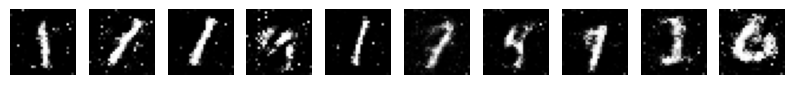

In [12]:
import matplotlib.pyplot as plt

# Generate new images
def generate_images(generator, num_images, latent_dim):
    # Menentukan status generator menjadi evaluation mode
    generator.eval()

    # Generate random noise
    z = torch.randn(num_images, latent_dim)

    # Generate images from noise
    gen_imgs = generator(z)

    # Rescale images menjadi rentang [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axs[i].imshow(gen_imgs[i].detach().numpy().squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.show()

# Generate dan menampilkan 10 gambar baru
generate_images(generator, 10, latent_dim)